# **Thonburian TTS** Demonstration

<p align="center">
  <img src="https://raw.githubusercontent.com/biodatlab/thonburian-tts/main/assets/ThonburianTTSLogo.png" width="400"/><br>
</p>

[🔊 Model Checkpoints](https://huggingface.co/biodatlab/ThonburianTTS) | [🤗 Gradio Demo](https://github.com/biodatlab/thonburian-tts/blob/main/gradio_app.py) | [📄 Thonburian TTS GitHub](https://github.com/biodatlab/thonburian-tts)

**Thonburian TTS** is a **Thai Text-to-Speech (TTS)** engine built on top of the [F5-TTS](https://github.com/SWivid/F5-TTS).  
It generates **natural and expressive Thai speech** by leveraging **Flow-Matching diffusion techniques** and can **mimic reference voices** from short audio samples. The system supports:

- **Thai language generation** (`language="th"`)
- **Reference-based voice cloning** using short audio clips
- High-quality synthesis with controllable speed and silence trimming

### **Pipeline Overview**

<img src="https://raw.githubusercontent.com/biodatlab/thonburian-tts/main/assets/tts-workflow.png" width="400" />

This workflow enables:
- **High-quality Thai speech generation** from text
- Voice cloning with **style and tone preservation**
- ASR-TTS integration for interactive voice applications

## Installs and imports

In [ ]:
# For TTS
!pip install f5-tts

In [ ]:
# For Utils
!pip install sounddevice wavio
!pip install ipywebrtc notebook

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.6 MB/s eta 0:00:00


In [ ]:
!apt install ffmpeg
!apt-get install libportaudio2

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  libportaudio2
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 65.3 kB of archives.
After this operation, 223 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudio2 amd64 19.6.0-1.1 [65.3 kB]
Fetched 65.3 kB in 1s (106 kB/s)
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../libportaudio2_19.6.0-1.1_amd64.deb ...
Unpacking libportaudio2:amd64 (19.6.0-1.1) ...
Setting up libportaudio2:amd64 (19.6.0-1.1) ...
Processing triggers for 

In [ ]:
!git clone https://github.com/biodatlab/thonburian-tts.git

Cloning into 'thonburian-tts'...
remote: Enumerating objects: 195, done.
remote: Counting objects: 100% (195/195), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 195 (delta 57), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (195/195), 2.04 MiB | 6.86 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [ ]:
import torch
import librosa
import librosa.display
from google.colab import output
from ipywebrtc import AudioRecorder, CameraStream
from IPython.display import Audio, display
import ipywidgets as widgets
import numpy as np
import os
import soundfile as sf
from transformers import pipeline
import matplotlib.pyplot as plt

In [ ]:
%cd thonburian-tts
from flowtts.inference import FlowTTSPipeline, ModelConfig, AudioConfig

/content/thonburian-tts


/usr/local/lib/python3.12/dist-packages/jieba/__init__.py:44: SyntaxWarning: invalid escape sequence '\.'
  re_han_default = re.compile("([\u4E00-\u9FD5a-zA-Z0-9+#&\._%\-]+)", re.U)
/usr/local/lib/python3.12/dist-packages/jieba/__init__.py:46: SyntaxWarning: invalid escape sequence '\s'
  re_skip_default = re.compile("(\r\n|\s)", re.U)
/usr/local/lib/python3.12/dist-packages/jieba/finalseg/__init__.py:78: SyntaxWarning: invalid escape sequence '\.'
  re_skip = re.compile("([a-zA-Z0-9]+(?:\.\d+)?%?)")


## Thonburian TTS Initialization

In [ ]:
# Determine device
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

cuda


In [ ]:
def transcribe_audio(audio_path: str, model_name: str = "biodatlab/whisper-th-medium-combined", lang="th") -> str:
    """
    Transcribe an audio file into text using Whisper ASR.

    Args:
        audio_path (str): Path to the audio file to transcribe.
        model_name (str): Name of the Whisper ASR model to use.
        lang (str): Language code for the transcription.

    Returns:
        str: Transcribed text. Returns empty string on error.
    """
    whisper_pipe = pipeline(
      task="automatic-speech-recognition",
      model=model_name,
      chunk_length_s=30,
      device=device,
    )

    whisper_pipe.model.config.forced_decoder_ids = whisper_pipe.tokenizer.get_decoder_prompt_ids(
        language=lang,
        task="transcribe"
    )

    if audio_path is None:
        return ""

    try:
        output = whisper_pipe(audio_path)
        return output["text"]
    except Exception as e:
        print(f"[ERROR] Transcription failed: {e}")
        return ""

def mel_generator(wav_path: str, mel_image_path: str) -> None:
    """
    Generate and save a Mel spectrogram image from a WAV audio file.

    Args:
        wav_path (str): Path to the generated WAV file.
        mel_image_path (str): Path where the Mel spectrogram image will be saved.
    """
    y, sr = librosa.load(wav_path, sr=None)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)

    os.makedirs(os.path.dirname(mel_image_path), exist_ok=True)

    plt.figure(figsize=(12, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar()
    plt.title("Mel Spectrogram")
    plt.tight_layout()
    plt.savefig(mel_image_path, dpi=200)
    plt.close()

def tts_inference(
    ref_audio: str,
    ref_text: str,
    gen_text: str,
    checkpoint: str,
    vocab_file: str,
    nfe_step: int = 32,
):
    """
    Run Thai TTS with reference voice cloning using FlowTTS (F5 model).

    Args:
        ref_audio (str): Path to reference speaker audio (3–10 seconds).
        ref_text (str): The text spoken in the reference audio.
        gen_text (str): The text to synthesize.
        checkpoint (str): Model checkpoint path or HF hub path.
        vocab_file (str): Path to vocabulary file.
        nfe_step (int): NFE steps for ODE (trade-off: better quality vs slower).

    Returns:
        tuple: (generated_audio_path, mel_image_path)
    """

    # Load model config
    model_config = ModelConfig(
        language="th",
        model_type="F5",
        checkpoint=checkpoint,
        vocab_file=vocab_file,
        ode_method="euler",
        use_ema=True,
        vocoder="vocos",
        device=device
    )

    # Audio generation config
    audio_config = AudioConfig(
        silence_threshold=-45,
        max_audio_length=20000,
        cfg_strength=2.5,
        nfe_step=nfe_step,
        target_rms=0.1,
        cross_fade_duration=0.15,
        speed=1.0,
        min_silence_len=500,
        keep_silence=200,
        seek_step=10
    )

    # Initialize the pipeline
    pipeline = FlowTTSPipeline(
        model_config=model_config,
        audio_config=audio_config,
        temp_dir="temp_f5"
    )

    # Save output files
    output_audio = "outputs_f5/generated.wav"
    output_mel = "outputs_f5/generated_mel.png"
    os.makedirs("outputs_f5", exist_ok=True)

    # Run inference
    pipeline(
        text=gen_text,
        ref_voice=ref_audio,
        ref_text=ref_text,
        output_file=output_audio,
        speed=1.0,
        check_duration=True
    )

    # Generate Mel spectrogram
    mel_generator(output_audio, output_mel)

    return output_audio, output_mel

## [Option 1] Recording for reference audio

In [ ]:
output.enable_custom_widget_manager()

camera = CameraStream(constraints={'audio': True,'video':False})
recorder = AudioRecorder(stream=camera)

recorder

AudioRecorder(audio=Audio(value=b'', format='webm'), stream=CameraStream(constraints={'audio': True, 'video': …

In [ ]:
# Convert Recording to Wav file and Replay
with open('recording.webm', 'wb') as f:
    f.write(recorder.audio.value)
!ffmpeg -i recording.webm -ac 1 -f wav reference.wav -y -hide_banner -loglevel panic

reference_audio = "/content/thonburian-tts/reference.wav"

from IPython.display import Audio
Audio(reference_audio, autoplay=True)

## [Option2] Upload wav file for reference audio

In [ ]:
# Upload Recording wav file and Replay

from google.colab import files
uploaded = files.upload()

reference_audio = list(uploaded.keys())[0]
print("Uploaded:", reference_audio)

from IPython.display import Audio
Audio(reference_audio, autoplay=True)

Saving mega_demo1.wav to mega_demo1 (3).wav
Uploaded: mega_demo1 (3).wav


## Transcribe the reference audio

In [ ]:
# Using Thonburian Whisper ASR Model
ASR_MODEL = "biodatlab/whisper-th-medium-combined"

reference_text = transcribe_audio(audio_path = reference_audio, model_name = ASR_MODEL)
print("TRANSCRIPTION:", reference_text)

Device set to use cuda
Using `chunk_length_s` is very experimental with seq2seq models. The results will not necessarily be entirely accurate and will have caveats. More information: https://github.com/huggingface/transformers/pull/20104. Ignore this warning with pipeline(..., ignore_warning=True). To use Whisper for long-form transcription, use rather the model's `generate` method directly as the model relies on it's own chunking mechanism (cf. Whisper original paper, section 3.8. Long-form Transcription).


TRANSCRIPTION: ทนายความของอดีตพระพรหมสิทธิ์บอกว่า เมื่อศาลไม่อนุญาตให้ประกันตัวนะครับ


## Speech Generation using reference audio and reference text

In [ ]:
CHECKPOINT = "hf://biodatlab/ThonburianTTS/megaF5/mega_f5_last.safetensors"
VOCAB = "hf://biodatlab/ThonburianTTS/megaF5/mega_vocab.txt"

In [ ]:
generated_wav, generated_mel = tts_inference(
    ref_audio=reference_audio,
    ref_text=reference_text,
    gen_text="ทนายความของอดีตพระพรหมสิทธิ์บอกว่า เมื่อศาลไม่อนุญาตให้ประกันตัวนะครับ",
    checkpoint=CHECKPOINT,
    vocab_file=VOCAB,
    nfe_step=32
)

generated_wav, generated_mel

mega_vocab.txt: 0.00B [00:00, ?B/s]

megaF5/mega_f5_last.safetensors:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

Download Vocos from huggingface charactr/vocos-mel-24khz


config.yaml:   0%|          | 0.00/461 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/54.4M [00:00<?, ?B/s]


vocab :  /root/.cache/huggingface/hub/models--biodatlab--ThonburianTTS/snapshots/1d34e90c6fb85684703c331b6d89a7215028f9da/megaF5/mega_vocab.txt
token :  custom
model :  /root/.cache/huggingface/hub/models--biodatlab--ThonburianTTS/snapshots/1d34e90c6fb85684703c331b6d89a7215028f9da/megaF5/mega_f5_last.safetensors 



/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

Converting audio...
Using custom reference text...

ref_text   ทนายความของอดีตพระพรหมสิทธิ์บอกว่า เมื่อศาลไม่อนุญาตให้ประกันตัวนะครับ. 
gen_text 0 ทนายความของอดีตพระพรหมสิทธิ์บอกว่า เมื่อศาลไม่อนุญาตให้ประกันตัวนะครับ


Generating audio in 1 batches...


100%|██████████| 1/1 [00:04<00:00,  4.67s/it]


Time taken is 4.91 seconds


('outputs_f5/generated.wav', 'outputs_f5/generated_mel.png')

## Listen to Output

🔊 Generated Audio:


📊 Mel Spectrogram:


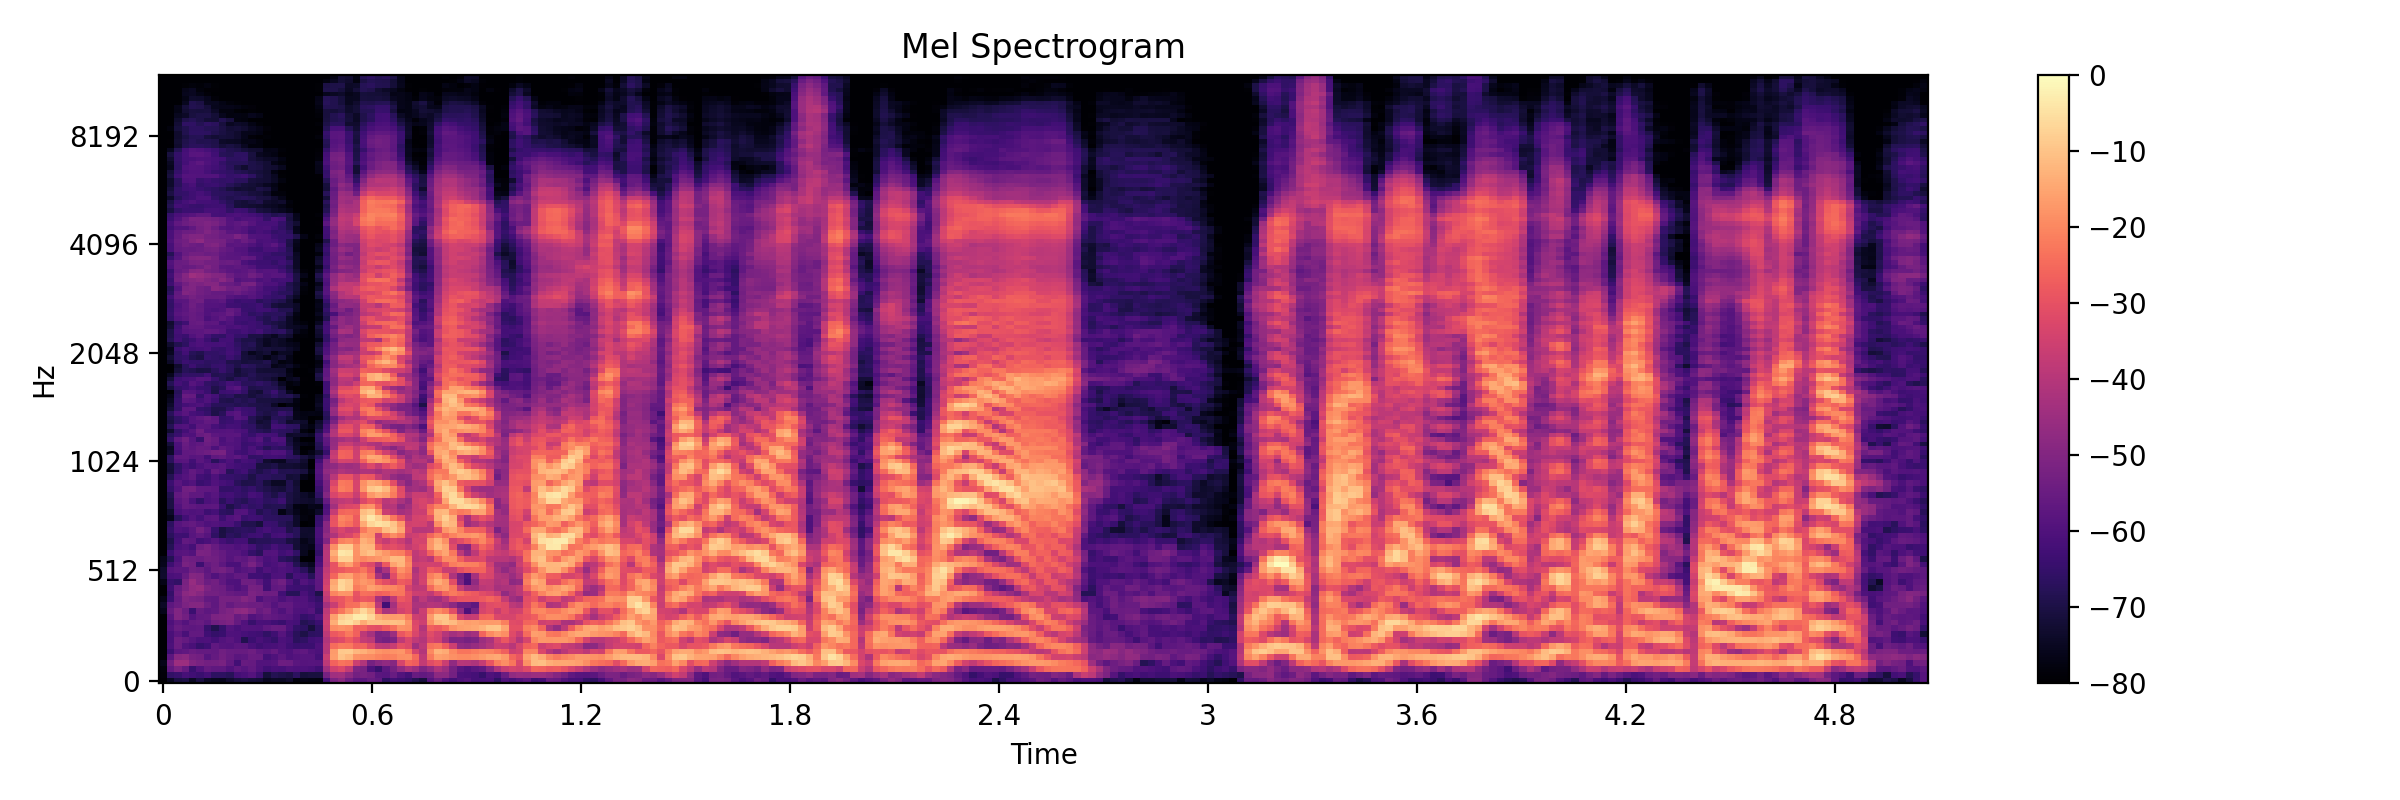

In [ ]:
from IPython.display import Audio, Image

print("🔊 Generated Audio:")
display(Audio(generated_wav, rate=22050))

print("📊 Mel Spectrogram:")
display(Image(generated_mel))